Can we predict the weather?

**Introduction**

Title

Spring 2024 Data Science Project

Kevin Canha

The main purpose of this document is to walk you through the process of doing real life datascience. This tutorial will guide you through the process step by step of finding a dataset, importing it into pandas, doing initial analysis on the data, and using it to try and predict the weather. The question we will be trying to answer is this "Can we predict temperatures based off of the data from this dataset?"



**Data Curation**

This stage of the process is most important, the results stem from the data, and if you have bad data, you will get bad results. I found [this public domain dataset on kaggle](https://www.kaggle.com/datasets/muthuj7/weather-dataset?resource=*download*). This is a dataset of weather data, containing information like temperature, humidity, wind speed, and a daily summary of the weather. I chose this data because it is from a reputable source, and after initial analysis, i found that it was a very complete set of data.

To download the dataset, head over to kaggle, log in, and hit download, easy as that! the dataset is public domain, so no need to worry about whether or not it is OK to use.

Lets see what the data looks like!

I will be using python in google copilot for this project, but this tutorial will be useful for any python3 setup.

We will start by importing all of the libraries we could possibly need.

we import the data into python as a pandas dataset, and do some formatting. The data is captured hourly, but all of the dates and times are displayed as utc, we want to be able to easily reference day, month, year, hour, so we do some feature engineering to obtain those.

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu
import calendar
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

weather_df = pd.read_csv("weatherHistory.csv")
weather_df['Formatted Date'] = pd.to_datetime(weather_df['Formatted Date'], utc=True)
weather_df['Year'] = weather_df['Formatted Date'].dt.year
weather_df['Month'] = weather_df['Formatted Date'].dt.month
weather_df['Day'] = weather_df['Formatted Date'].dt.day
weather_df['Hour'] = weather_df['Formatted Date'].dt.hour


At this point, the dataset has been imported into pandas, and necessary  features have been added

**Exploratory Data Analysis**

Lets start our data analysis by getting a good look at the data, we can plot the monthly average temperatures for each year like this:

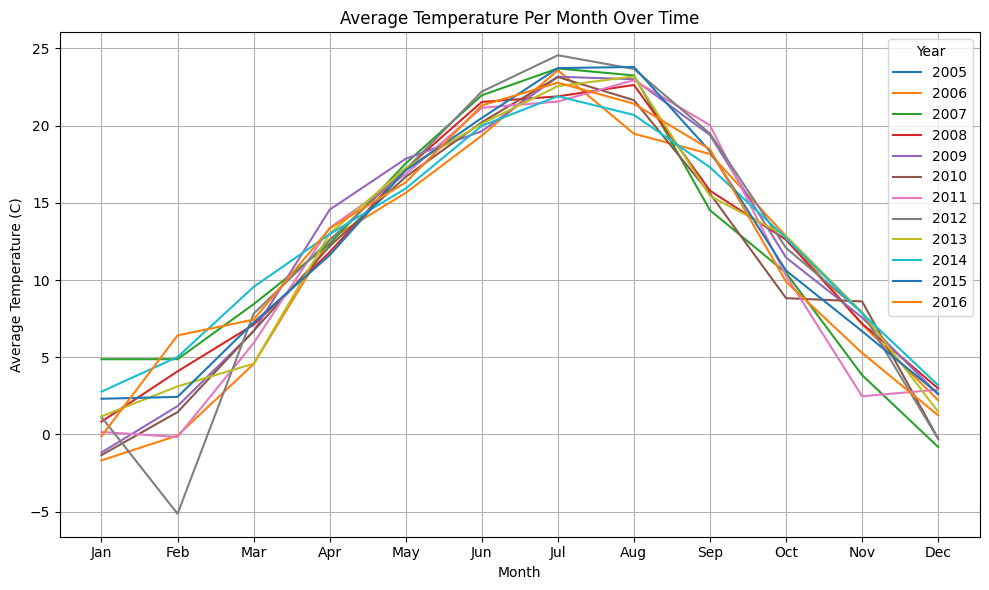

In [100]:
# Plot the average temperatures per month to put the information in context
# Group by year and month and calculate the average temperature
monthly_average_temperature = weather_df.groupby(['Year', 'Month'])['Temperature (C)'].mean().reset_index()

# Plot the data
plt.figure(figsize=(10, 6))
for year, group in monthly_average_temperature.groupby('Year'):
    plt.plot(group['Month'], group['Temperature (C)'], label=str(year))

plt.title('Average Temperature Per Month Over Time')
plt.xlabel('Month')
plt.ylabel('Average Temperature (C)')
plt.xticks(range(1, 13), [calendar.month_abbr[i] for i in range(1, 13)])  # Convert month numbers to names
plt.legend(title='Year', loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

Lets do some analysis of the dataset, will the dataset help in predicting all of the months equally? we can use an ANOVA test to find the variance of each month

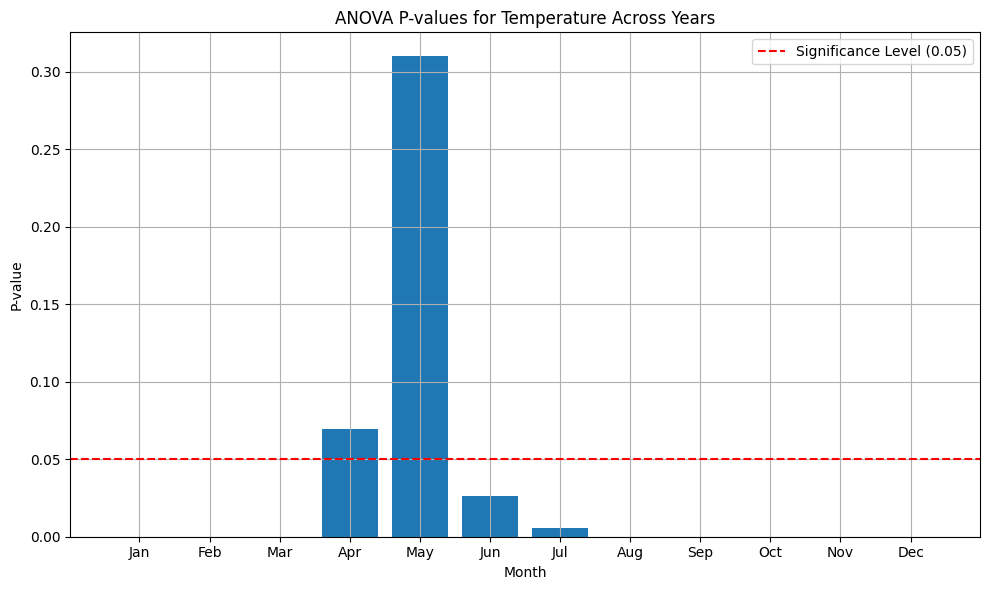

In [101]:
# Group by year and month and calculate the average temperature
monthly_average_temperature = weather_df.groupby(['Year', 'Month', 'Day'])['Temperature (C)'].mean().reset_index()

# Perform ANOVA for each month across different years
p_values = {}
for month in range(1, 13):
    data = [group['Temperature (C)'].values for _, group in monthly_average_temperature[monthly_average_temperature['Month'] == month].groupby('Year')]
    _, p_value = f_oneway(*data)
    p_values[month] = p_value

# Print the p-values for each month
#print("P-values for each month:")
#for month, p_value in p_values.items():
#    print(f"Month {month}: p-value = {p_value}")

# Plot the p-values
plt.figure(figsize=(10, 6))
plt.bar(p_values.keys(), p_values.values())
plt.title('ANOVA P-values for Temperature Across Years')
plt.xlabel('Month')
plt.ylabel('P-value')
plt.xticks(range(1, 13), [calendar.month_abbr[i] for i in range(1, 13)])  # Convert month numbers to names
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


From this data, it seems that some months have a signifigant difference, and some months do not. months with very low p-values indicate that the null hypothesis should be rejected, Jan, Feb, Mar, jun, jul, aug, sept, oct, nov all have very low p-values Months with High p-values like april and march have a very small temperature spread throughout the years

In conclusion, it seems there are signifigant shifts in average temperature for some months, and not for others.

What about the integrity of the dataset? is it complete? are there any missing values?

Year 2012:
- Precip Type: 143 missing data points
Year 2016:
- Precip Type: 374 missing data points


<Figure size 1000x600 with 0 Axes>

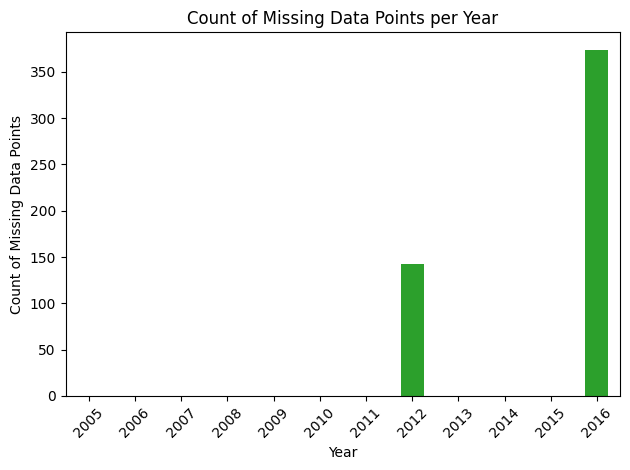

Mann-Whitney U Test Results:
Statistic: 2.0
P-value: 0.6666666666666666


In [102]:
# Count missing values per year
missing_data_per_year = weather_df.groupby('Year').apply(lambda x: x.isnull().sum())

# Plot the count of missing data per year
plt.figure(figsize=(10, 6))
missing_data_per_year.plot(kind='bar', stacked=True, legend=False)
plt.title('Count of Missing Data Points per Year')
plt.xlabel('Year')
plt.ylabel('Count of Missing Data Points')
plt.xticks(rotation=45)

# Print the kinds of data that were missing for each year
for year, missing_data in missing_data_per_year.iterrows():
    for column, count in missing_data.items():
        if count > 0:
            print(f"Year {year}:")
            print(f"- {column}: {count} missing data points")

plt.tight_layout()
plt.show()


# Extract the count of missing data points for the years 2012 and 2016
missing_2012 = weather_df[weather_df['Year'] == 2012]['Precip Type'].isnull().sum()
missing_2016 = weather_df[weather_df['Year'] == 2016]['Precip Type'].isnull().sum()

# Extract the count of missing data points for other years
missing_other_years = weather_df[(weather_df['Year'] != 2012) & (weather_df['Year'] != 2016)]['Precip Type'].isnull().sum()

# Perform the Mann-Whitney U test
statistic, p_value = mannwhitneyu([missing_2012, missing_2016], missing_other_years)

# Print the results
print("Mann-Whitney U Test Results:")
print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

This Plot shows counts of missing data. In both 2012 and 2016 there was missing data for precipitation type. It is possible that this is because there was no precipitation, it is also possible that the data has been lost or corrupted. Moving forwards, while working on the precipitation type data, i will not use these entries with missing info.

Is the amount of missing data signifigant?

From the results of the Mann-Whitney U test, it can be concluded that even though there was missing data, the amount of missing data between years is not signifigant. This can be concluded as the p=value of the test came out to .666 which is much greater than .05 which leads to a failure to reject the null.

Even if the missing data was signifigant, it wouldn't matter to us, as the missing data is of type "precipitaion type", and we are only worried about temperature, and as our tests showed that there are no missing temperature datapoints, we can disregard this.

Lets see what else we can do with our data. Lets try to figure out whether or not every month has a similar temperature spread?

ANOVA p-value: 0.012179225030471662


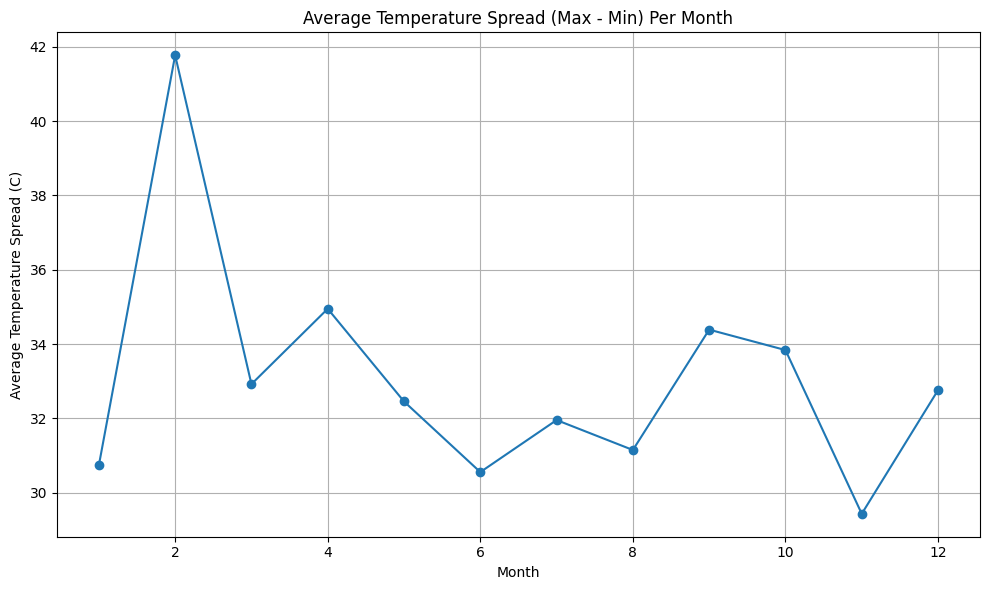

In [103]:
# Group by year, and month and calculate the temperature spread
monthly_spread = (weather_df.groupby(['Month'])
                  .apply(lambda x: x['Temperature (C)'].max() - x['Temperature (C)'].min())
                  .reset_index(name='Temperature Spread'))

# Calculate the average temperature spread per month for the graph
average_spread_per_month = monthly_spread.groupby('Month')['Temperature Spread'].mean().reset_index()


# Calculate the temperature spread for each month, for each year for the ANOVA test
monthly_yearly_spread = (weather_df.groupby(['Year', 'Month'])
                         .apply(lambda x: x['Temperature (C)'].max() - x['Temperature (C)'].min())
                         .reset_index(name='Temperature Spread'))


#Calculate ANOVA test
anova_result = f_oneway(*[group['Temperature Spread'] for name, group in monthly_yearly_spread.groupby('Month')])
print("ANOVA p-value:", anova_result.pvalue)


# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(average_spread_per_month['Month'], average_spread_per_month['Temperature Spread'], marker='o', linestyle='-')
plt.title('Average Temperature Spread (Max - Min) Per Month')
plt.xlabel('Month')
plt.ylabel('Average Temperature Spread (C)')
plt.grid(True)
plt.tight_layout()
plt.show()

The Resulting P-Value from running this test comes out to p-value = 0.012179225030471662 This means that, with a level of signifigance of 95%, we reject the null hypothesis, that all months have a similar temperature spread as .01217... < .05

This means that some months have a larger temperature spread on average than others

From our exploratory analysis of the dataset, a few things can be concluded. In summary, it can be concluded that over the years, some months have a signifigant temperature difference while others do not, that some months have a signifigant difference in average temperature thoughout the month while others do not, and that the dataset contains some missing data but not enough to be signifigant.

**Primary Analysis**

For the primary analysis of the dataset, we will be using a polynomial regression model.
This is the best model for the job as it is a non-linear approach. From our analysis, the temperature data appears quadratic, so it is fitting to use a polynomial regression with a degree of two. This model will help predict temperatures.
Lets train the model on a subset of our data, and analyze it on another subset. An intuitive way to break up this data is to use 9 years of data (2006-2015) to predict the 10th (2016).
For this analysis we are using regression rather than classification or clustering, as we are trying to predict a best guess of temperature which is a continuous value. Regression is the obvious choice as it is used to predict continuous features, while clustering and classification are binary so these approaches would not work for this application.


**LinearRegression model with polynomial features**

In [104]:
#set up another df for later
weather_df_rf = weather_df.copy()

In [105]:
# Group the dataset by year, month, and day and calculate the average temperature along with other features
daily_average_temperature = weather_df.groupby(['Year', 'Month', 'Day']).agg({'Temperature (C)': 'mean'}).reset_index()

# To make things simpler, we will only be using temperature data, not any of the other weather data
features = ['Month', 'Day','Temperature (C)']

# Split data into training (2006-2015) and testing (2016)
train_data = daily_average_temperature[daily_average_temperature['Year'] <= 2015][features]
test_data = daily_average_temperature[daily_average_temperature['Year'] == 2016][features]

# Separate features and target variable
X_train, y_train = train_data.drop(columns=['Temperature (C)']), train_data['Temperature (C)']
X_test, y_test = test_data.drop(columns=['Temperature (C)']), test_data['Temperature (C)']

# Training the model using linear regression with polynomial features allows you to fit a polynomial equation to the data - this teqnique lets you use curves instead of straight lines
# Set up Polynomial features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Train the model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Model Evaluation, these are the predictions that will be displayed
predictions = model.predict(X_test_poly)


We have just trained our model, and predicted the values for 2016. Before we look at the data in a pretty graph, lets get an idea of how well our model did at predicting the weather.

In [106]:
# Calculate the mean error
mae = mean_absolute_error(y_test, predictions)

print("Mean Absolute Error (MAE):", mae)

absolute_errors = np.abs(predictions - y_test)

# Find the smallest and largest error
max_error = np.max(absolute_errors)
min_error = np.min(absolute_errors)
print("Greatest Error (Maximum Absolute Difference):", max_error)
print("Least Error (Minimum Absolute Difference):", min_error)

Mean Absolute Error (MAE): 3.010452451893641
Greatest Error (Maximum Absolute Difference): 13.217389755831423
Least Error (Minimum Absolute Difference): 0.012035100838471813


The average error was 3 degrees celsius, thats not amazing!
Lets try to find out if the error is concentrated anywhere.

**Visualization**

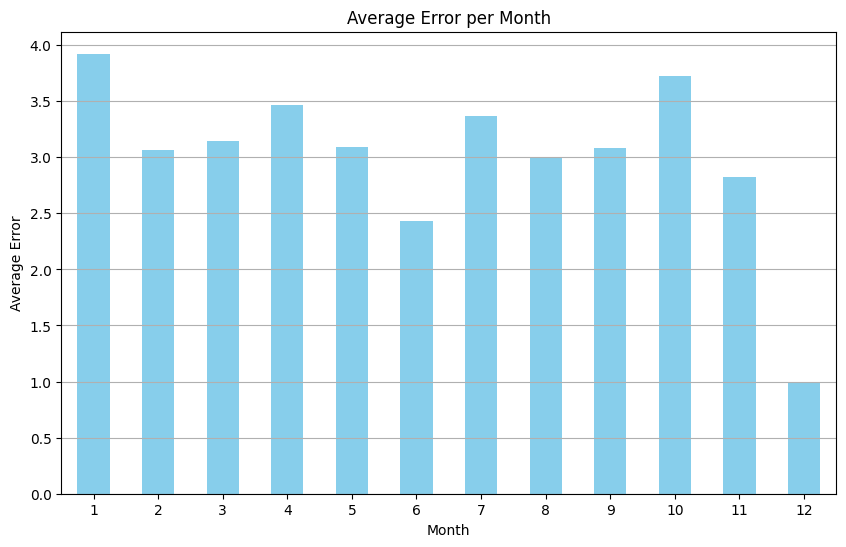

In [107]:
# find error
absolute_errors = np.abs(predictions - y_test)

# avg error per month
monthly_average_error = absolute_errors.groupby(test_data['Month']).mean()

# Plotting
plt.figure(figsize=(10, 6))
monthly_average_error.plot(kind='bar', color='skyblue')
plt.title('Average Error per Month')
plt.xlabel('Month')
plt.ylabel('Average Error')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()

It looks like the error is pretty evenly spread out, with the exception of december being easy to predict

To see what we are working with, lets plot the actual values of 2016 vs the predicted values.

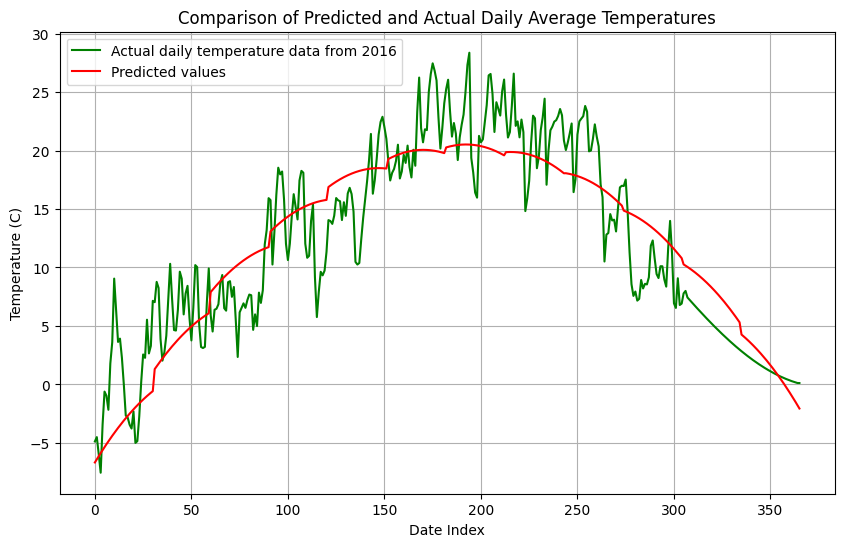

In [108]:
# Plot the test data vs our predictions
plt.figure(figsize=(10, 6))
x_values = range(len(y_test))
plt.plot(x_values, y_test, label='Actual daily temperature data from 2016', color='green')
plt.plot(x_values, predictions, label='Predicted values', color='red')
plt.title('Comparison of Predicted and Actual Daily Average Temperatures')
plt.xlabel('Date Index')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)
plt.show()

It looks like our predictions were not too far off overall. The curve follows our data pretty well, though with a possible error of up to 12 degrees celsius, it might not be too useful on a day to day basis.

Our machine learning approach was able to approximate the average temperature throughout the year. This minimal approach used a very simple model, and an open liscence dataset to do a pretty good job guessing the temperatures throughout the year.
Linear regression is quite suceptible to outliers, and is not optimal for handling non-linear relationships, even though we were able to get a good approximation with polynomial features.
We can do better, lets try a different approach, random forest regression is better at capturing non-linear relationships, lets see if it perferms better in practice

**Secondary analysis - Random Forest Regression**

In [109]:
# Group the dataset by year, month, and day and calculate the average temperature along with other features
daily_average_temperature_rf = weather_df_rf.groupby(['Year', 'Month', 'Day']).agg({'Temperature (C)': 'mean'}).reset_index()

# Only using some of the dataset's features for this model
features_rf = ['Month', 'Day','Temperature (C)']

# Split data into training (2006-2015) and testing (2016)
train_data_rf = daily_average_temperature_rf[daily_average_temperature_rf['Year'] <= 2015][features_rf]
test_data_rf = daily_average_temperature_rf[daily_average_temperature_rf['Year'] == 2016][features_rf]

# Separate features and target variable
X_train_rf, y_train_rf = train_data_rf.drop(columns=['Temperature (C)']), train_data_rf['Temperature (C)']
X_test_rf, y_test_rf = test_data_rf.drop(columns=['Temperature (C)']), test_data_rf['Temperature (C)']

# Set up Random Forest regressor
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model
model_rf.fit(X_train_rf, y_train_rf)

# Predict
predictions_rf = model_rf.predict(X_test_rf)


Lets quanitfy how well our predictions were, were they better than linear regression like we expected?

In [110]:
# Model Evaluation for Random Forest
mse_rf = mean_squared_error(y_test_rf, predictions_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test_rf, predictions_rf)
absolute_errors_rf = np.abs(predictions_rf - y_test_rf)
max_error_rf = np.max(absolute_errors_rf)
min_error_rf = np.min(absolute_errors_rf)
# Model Evaluation

rf_mse = mean_squared_error(y_test_rf, predictions_rf)
print("Random Forest MAE:", mae_rf)
print("Random Forest Maximum Absolute Difference:", max_error_rf)
print("Random Forest Minimum Absolute Difference:", min_error_rf)

Random Forest MAE: 2.7204954784826962
Random Forest Maximum Absolute Difference: 10.50586037403633
Random Forest Minimum Absolute Difference: 0.010687650181809616


Mean error of 2.7, that is better than what we got before (3.0)! 10 degree error maximum is not great, but definatly better than 13.2

**Visualization part 2**

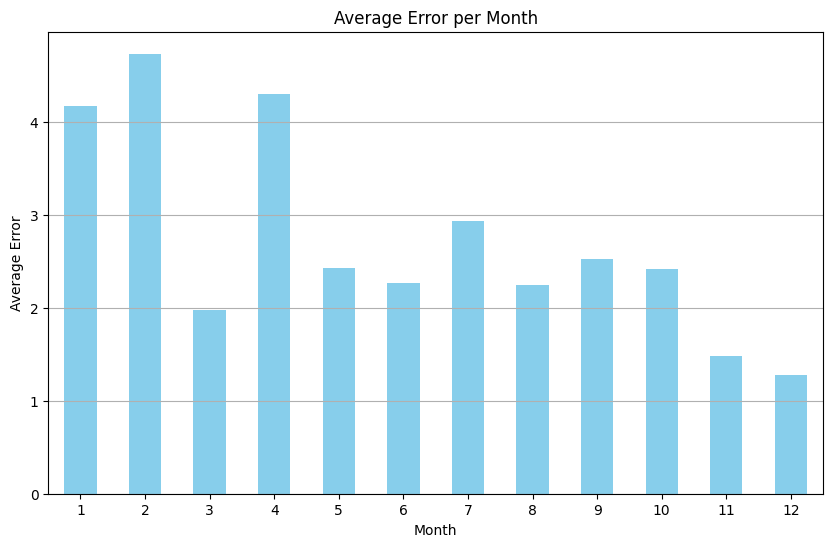

In [111]:
# find error
absolute_errors_rf = np.abs(predictions_rf - y_test_rf)

# avg error per month
monthly_average_error_rf = absolute_errors_rf.groupby(test_data_rf['Month']).mean()

# Plotting
plt.figure(figsize=(10, 6))
monthly_average_error_rf.plot(kind='bar', color='skyblue')
plt.title('Average Error per Month')
plt.xlabel('Month')
plt.ylabel('Average Error')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()

Overall the error is much lower, months like jan, feb, april still have pretty high error, but being off by ~2 degrees is not bad! The results of this approach would be more useful on a day to day basis than our first attempt

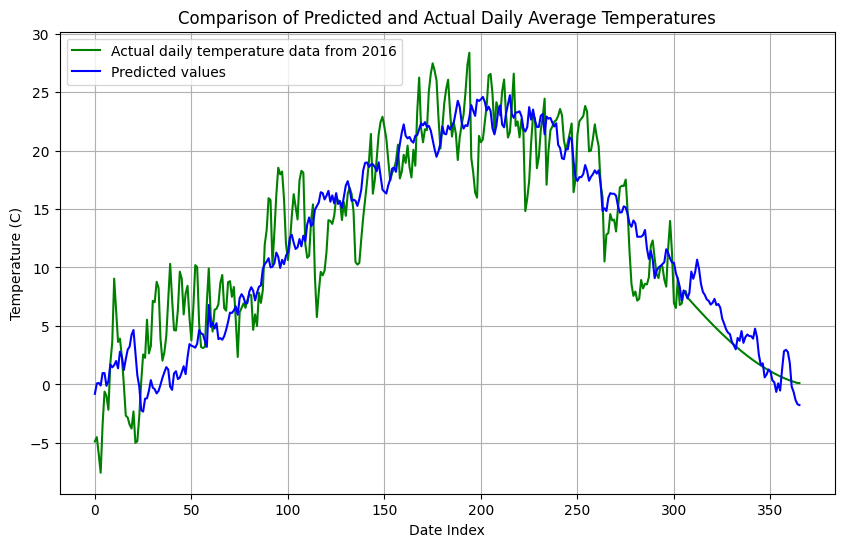

In [112]:
# Plot the test data vs our predictions
plt.figure(figsize=(10, 6))
x_values_rf = range(len(y_test_rf))
plt.plot(x_values_rf, y_test_rf, label='Actual daily temperature data from 2016', color='green')
plt.plot(x_values_rf, predictions_rf, label='Predicted values', color='blue')
plt.title('Comparison of Predicted and Actual Daily Average Temperatures')
plt.xlabel('Date Index')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)
plt.show()

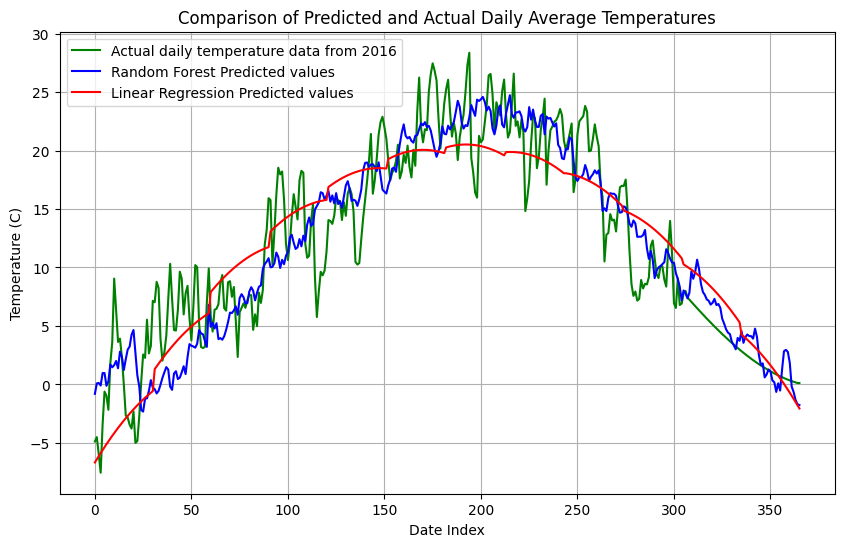

In [113]:
# Plot the test data vs predictions for both models
plt.figure(figsize=(10, 6))

# Plot actual temperature data
plt.plot(x_values_rf, y_test_rf, label='Actual daily temperature data from 2016', color='green', linestyle='-')

# Plot Random Forest predictions
plt.plot(x_values_rf, predictions_rf, label='Random Forest Predicted values', color='blue', linestyle='-')

# Plot Linear Regression predictions
plt.plot(x_values_rf, predictions, label='Linear Regression Predicted values', color='red', linestyle='-')

plt.title('Comparison of Predicted and Actual Daily Average Temperatures')
plt.xlabel('Date Index')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)
plt.show()

From this graph, it is pretty clear to see that the random forest model did a better job of predicting. The Linear regression model did a worse job of fitting to the data, with a very flat curve, while the Random forest model had a much rougher shape. The rougher shape of the random forest model seems to have lent itself to approximating the rough shape of the real data.

An AI built like this might not be replacing the weather channel anytime soon, but the random forest model accurately predicted the temperature much of the time.

In this tutorial we covered how to find a dataset, how to import it into pandas, how to do initial analysis of the dataset, how to train multiple types of machine learning models on the data, and how to compare their effectiveness.